# Import

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
device = torch.device("mps" if torch.backends.mps.is_available() else torch.device('cpu'))

In [4]:
from torchvision import datasets
from torch.utils.data import DataLoader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])


batch_size = 100

trainset = datasets.FashionMNIST(root='~/.pytorch/FashionMNIST_data/', train=True,
                                        download=True, transform=transform)

mask_1 = trainset.targets == 2
mask_2 = trainset.targets == 7
mask = mask_1 | mask_2
trainset = torch.utils.data.Subset(trainset, torch.where(mask)[0])


trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

mask_1 = testset.targets == 2
mask_2 = testset.targets == 7
mask = mask_1 | mask_2
testset = torch.utils.data.Subset(testset, torch.where(mask)[0])


testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('2', '7')

In [5]:
def change_label (label, n_0, n_1):
    mask_0, mask_1 = (label == n_0), (label == n_1)
    label[mask_0], label[mask_1] = 0, 1
    return label



In [6]:
len(trainset), len(testset)

(12000, 2000)

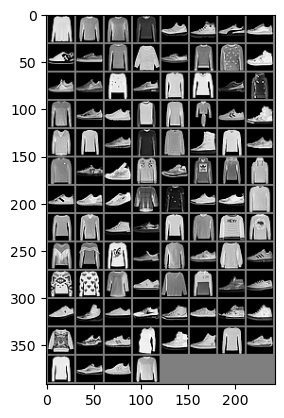

IndexError: tuple index out of range

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        change_label(labels, 2, 7)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.000
[1,   101] loss: 0.008
[2,     1] loss: 0.000
[2,   101] loss: 0.007
[3,     1] loss: 0.000
[3,   101] loss: 0.005
[4,     1] loss: 0.000
[4,   101] loss: 0.005
[5,     1] loss: 0.000
[5,   101] loss: 0.004
Finished Training


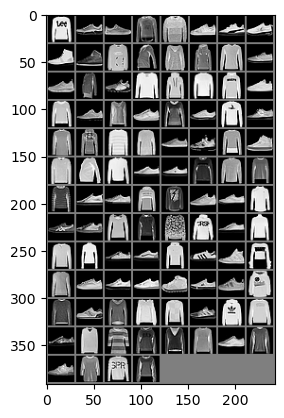

IndexError: tuple index out of range

In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Performance

In [11]:
net = Net()
net.load_state_dict(torch.load("./reco/fashion_reco.pth"))

<All keys matched successfully>

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(100)))

Predicted:  2     7     7     2     2     7     7     7     7     7     2     2     2     2     2     7     7     2     7     2     2     2     2     7     2     7     2     7     2     7     2     7     2     2     2     2     7     7     2     7     2     2     2     7     7     2     2     2     2     7     7     2     2     7     7     2     7     7     2     2     2     2     7     2     2     2     7     7     2     7     7     2     2     7     7     7     7     7     7     2     2     7     2     2     2     7     2     2     7     2     2     2     2     2     7     2     7     2     2     2    


In [14]:
images[:25].shape

torch.Size([25, 1, 28, 28])

In [15]:
torch.max(outputs[2:3],1)

torch.return_types.max(
values=tensor([3.7127], grad_fn=<MaxBackward0>),
indices=tensor([1]))

In [16]:
net(images[2:3])

tensor([[-3.4532,  3.7127]], grad_fn=<AddmmBackward0>)

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        change_label(labels, 2, 7)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 100 %


In [18]:
correct

2000